Initial rows, cols: (2400, 15)
Columns: ['location_id', 'location_name', 'parameter', 'value', 'unit', 'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude', 'country_iso', 'isMobile', 'isMonitor', 'owner_name', 'provider']
Pivoted shape: (480, 6)
Saved cleaned pivoted file: outputs\cleaned_air_quality_wide.csv


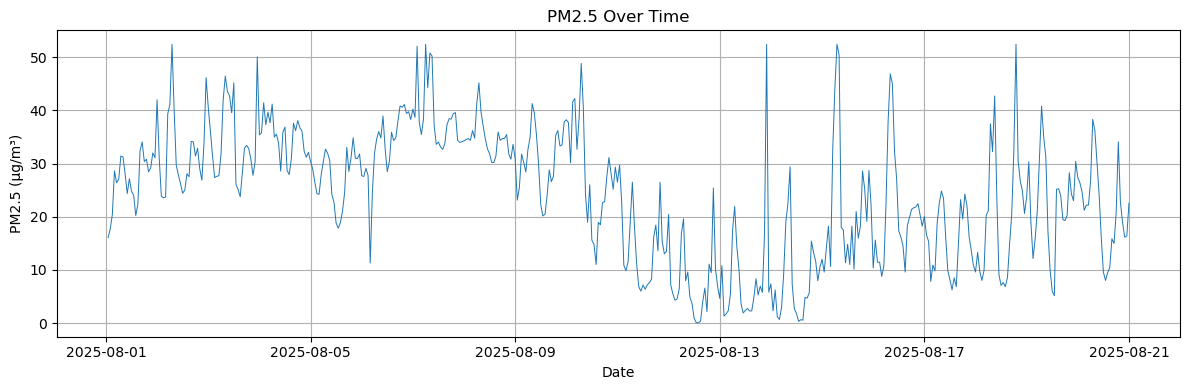

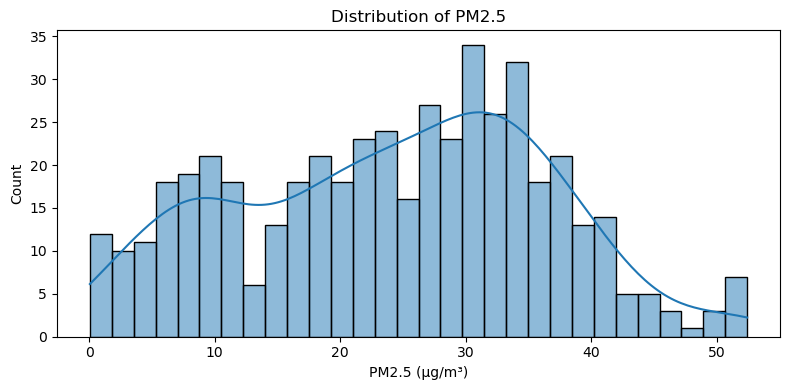

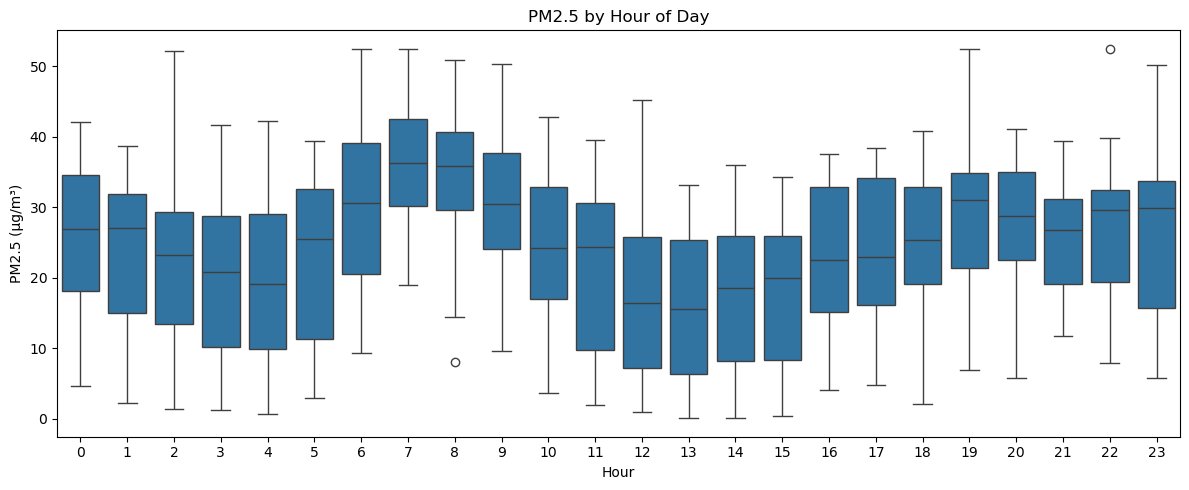

C:\Users\hp\AppData\Local\Temp\ipykernel_10808\250079772.py:117: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="day_name", y="pm25", data=df_pivot, ci="sd", order=order, palette="viridis")
C:\Users\hp\AppData\Local\Temp\ipykernel_10808\250079772.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day_name", y="pm25", data=df_pivot, ci="sd", order=order, palette="viridis")


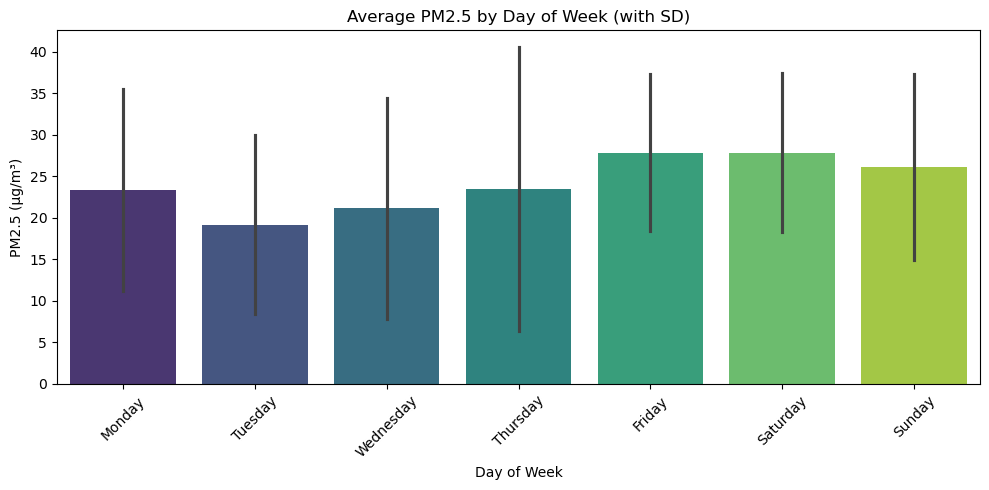

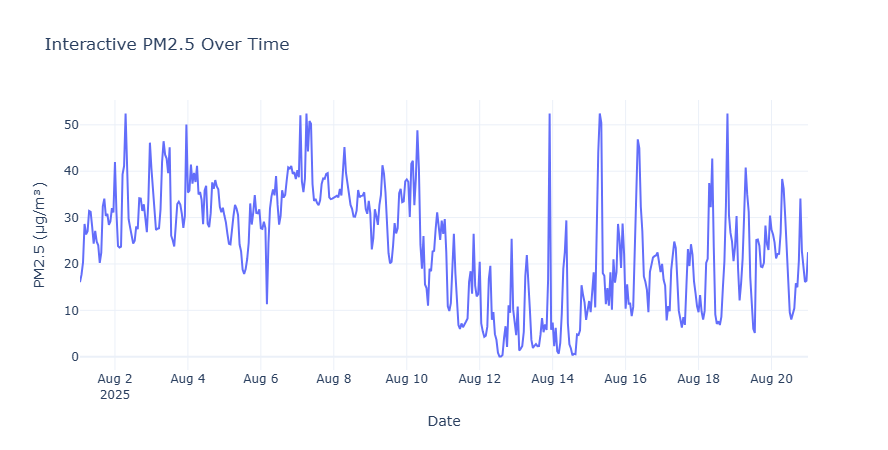

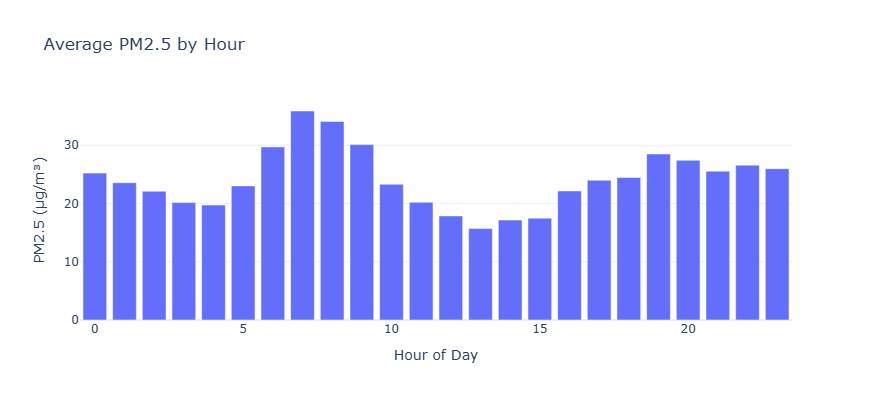

Rows available for modeling: 478
Training rows: 382 Test rows: 96


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Test RMSE: 1.337 µg/m³
Test R²: 0.980


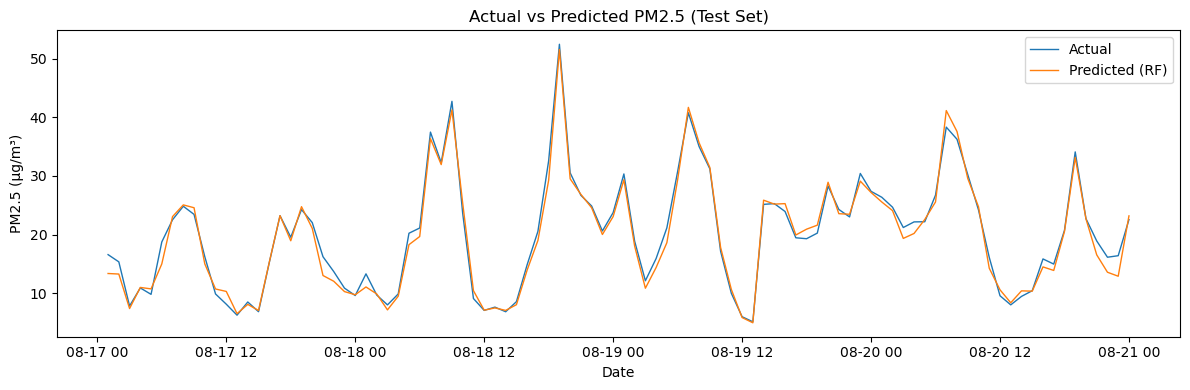

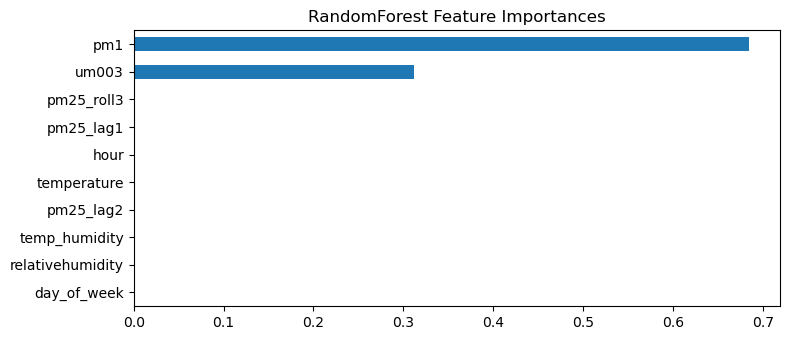


Done! All outputs saved in 'outputs/' folder.


In [1]:
# air_quality_pipeline_clean.py
# Full air quality analysis & RandomForest modeling pipeline
# ----------------------------------------------

import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.dates import AutoDateLocator, DateFormatter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------
# Config / Output folder
# ------------------------
CSV = "openaq_location_4948390_measurments.csv"
OUT = "outputs"
os.makedirs(OUT, exist_ok=True)

# ------------------------
# 1) Load data safely
# ------------------------
try:
    df = pd.read_csv(CSV)
except FileNotFoundError:
    raise SystemExit(f"File not found: {CSV}. Place your CSV in the folder or update the path.")

print("Initial rows, cols:", df.shape)
print("Columns:", df.columns.tolist())

# ------------------------
# 2) Normalize datetime & minimal cleaning
# ------------------------
if "datetimeLocal" not in df.columns:
    raise SystemExit("Expected column 'datetimeLocal' not found.")

df["datetimeLocal"] = pd.to_datetime(df["datetimeLocal"], errors="coerce")
df = df.dropna(subset=["datetimeLocal"])  # Drop rows where datetime parsing failed

drop_cols = ["location_id", "location_name", "timezone", "owner_name", "provider", 
             "country_iso", "isMobile", "isMonitor"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# ------------------------
# 3) Pivot to wide format (one column per parameter)
# ------------------------
df_pivot = df.pivot(index="datetimeLocal", columns="parameter", values="value").sort_index().reset_index()
print("Pivoted shape:", df_pivot.shape)

# Estimate pm25 if missing
if "pm25" not in df_pivot.columns:
    if "pm1" in df_pivot.columns:
        print("Estimating PM2.5 from PM1 (pm25 = pm1 / 0.7)")
        df_pivot["pm25"] = df_pivot["pm1"] / 0.7
    else:
        raise SystemExit("pm25 missing and cannot be estimated. Need pm25 or pm1.")

# ------------------------
# 4) Add weather columns (mock if missing)
# ------------------------
if "temperature" not in df_pivot.columns:
    df_pivot["temperature"] = np.random.uniform(20, 30, size=len(df_pivot))
if "relativehumidity" not in df_pivot.columns:
    df_pivot["relativehumidity"] = np.random.uniform(60, 95, size=len(df_pivot))

# Clip extreme pm25
df_pivot["pm25"] = df_pivot["pm25"].clip(upper=df_pivot["pm25"].quantile(0.99))

# Save cleaned wide CSV
clean_csv = os.path.join(OUT, "cleaned_air_quality_wide.csv")
df_pivot.to_csv(clean_csv, index=False)
print("Saved cleaned pivoted file:", clean_csv)

# ------------------------
# 5) EDA: static plots
# ------------------------
# Time series
plt.figure(figsize=(12,4))
plt.plot(df_pivot["datetimeLocal"], df_pivot["pm25"], lw=0.7)
plt.title("PM2.5 Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pm25_timeseries.png"), dpi=200)
plt.show()

# Distribution
plt.figure(figsize=(8,4))
sns.histplot(df_pivot["pm25"], kde=True, bins=30)
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pm25_distribution.png"), dpi=200)
plt.show()

# Hourly boxplot
df_pivot["hour"] = df_pivot["datetimeLocal"].dt.hour
plt.figure(figsize=(12,5))
sns.boxplot(x="hour", y="pm25", data=df_pivot)
plt.title("PM2.5 by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pm25_by_hour_boxplot.png"), dpi=200)
plt.show()

# Day of week barplot
df_pivot["day_name"] = df_pivot["datetimeLocal"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.figure(figsize=(10,5))
sns.barplot(x="day_name", y="pm25", data=df_pivot, ci="sd", order=order, palette="viridis")
plt.title("Average PM2.5 by Day of Week (with SD)")
plt.xlabel("Day of Week")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pm25_by_dayofweek.png"), dpi=200)
plt.show()

# ------------------------
# 6) Interactive Plotly plots
# ------------------------
# Time series
fig = px.line(df_pivot, x="datetimeLocal", y="pm25", 
              title="Interactive PM2.5 Over Time",
              labels={"datetimeLocal":"Date", "pm25":"PM2.5 (µg/m³)"})
fig.update_layout(template="plotly_white", height=450)
fig.write_html(os.path.join(OUT, "interactive_pm25_timeseries.html"))
fig.show()

# Hourly average
hourly = df_pivot.groupby("hour", as_index=False)["pm25"].mean()
fig2 = px.bar(hourly, x="hour", y="pm25", 
              title="Average PM2.5 by Hour",
              labels={"pm25":"PM2.5 (µg/m³)", "hour":"Hour of Day"})
fig2.update_layout(template="plotly_white", height=400)
fig2.write_html(os.path.join(OUT, "interactive_hourly_avg.html"))
fig2.show()

# ------------------------
# 7) Feature engineering for modeling
# ------------------------
df_model = df_pivot.copy().sort_values("datetimeLocal").reset_index(drop=True)
df_model["day_of_week"] = df_model["datetimeLocal"].dt.dayofweek
df_model["pm25_lag1"] = df_model["pm25"].shift(1)
df_model["pm25_lag2"] = df_model["pm25"].shift(2)
df_model["pm25_roll3"] = df_model["pm25"].rolling(window=3, min_periods=1).mean()
df_model["temp_humidity"] = df_model["temperature"] * df_model["relativehumidity"]
df_model = df_model.dropna().reset_index(drop=True)
print("Rows available for modeling:", len(df_model))

# ------------------------
# 8) Train/test split (time-aware)
# ------------------------
candidate_features = ["pm1", "um003", "temperature", "relativehumidity", "hour",
                      "day_of_week", "temp_humidity", "pm25_lag1", "pm25_lag2", "pm25_roll3"]
features = [f for f in candidate_features if f in df_model.columns]

X = df_model[features]
y = df_model["pm25"]

split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print("Training rows:", len(X_train), "Test rows:", len(X_test))

# ------------------------
# 9) Train RandomForest
# ------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=4,
                           min_samples_leaf=2, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f} µg/m³")
print(f"Test R²: {r2:.3f}")

# Save model and metrics
joblib.dump(rf, os.path.join(OUT, "rf_baseline.pkl"))
metrics = {"rmse": float(rmse), "r2": float(r2), "n_train": len(X_train),
           "n_test": len(X_test), "features": features}
with open(os.path.join(OUT, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# ------------------------
# 10) Save predictions + static actual vs predicted plot
# ------------------------
pred_df = pd.DataFrame({
    "datetimeLocal": df_model["datetimeLocal"].iloc[split_idx:].values,
    "actual_pm25": y_test.values,
    "predicted_pm25": y_pred
})
pred_df.to_csv(os.path.join(OUT, "predictions.csv"), index=False)

plt.figure(figsize=(12,4))
plt.plot(pred_df["datetimeLocal"], pred_df["actual_pm25"], label="Actual", lw=1)
plt.plot(pred_df["datetimeLocal"], pred_df["predicted_pm25"], label="Predicted (RF)", lw=1)
plt.legend()
plt.title("Actual vs Predicted PM2.5 (Test Set)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "actual_vs_predicted.png"), dpi=200)
plt.show()

# ------------------------
# 11) Feature importance
# ------------------------
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(8, max(3, 0.35*len(fi))))
fi.plot(kind="barh")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "feature_importance.png"), dpi=200)
plt.show()

print("\nDone! All outputs saved in 'outputs/' folder.")
